I'm getting a little bored of this project, so i'll add a brief analysis of the original 307k posts i pulled from the pushshift API. My original goal was to see if bot activity increased or decreased around the time of Russia's invasion of Ukraine then quickly got out of hand when i realized making a model to predict bots was going to be difficult. I pulled all reddit posts from 2/1/2022 through 6/10/2022 from the following subreddits:

In [1]:
import psycopg2
conn = psycopg2.connect(dbname='reddit-db', user="postgres", host='localhost', password='password', port='5432')
cur = conn.cursor()

get_subreddit_info_sql = """
select subreddit, count(*) as "Number of Posts"
from 
	(select split_part(permalink, '/',3) as subreddit 
 	from posts) as sub
group by subreddit
order by subreddit asc
"""
cur.execute(get_subreddit_info_sql)
subreddit_summary = cur.fetchall()
subreddit_names = []
subreddit_post_count =  []
for i in subreddit_summary:
    subreddit_names.append(i[0])
    subreddit_post_count.append(i[1])

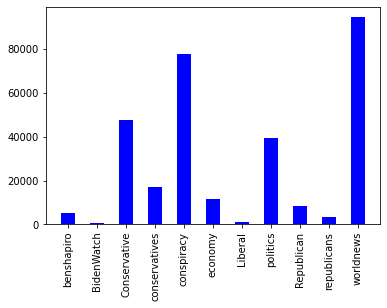

In [2]:
import matplotlib.pyplot as plt
plt.bar(subreddit_names, subreddit_post_count, width=0.5, color='blue')
plt.xticks(rotation=90)
plt.show()

r/WorldNews represents the most posts, followed by r/conspiracy, then r/Conservative. I wanted to get multiple political points, but reddit is inherently more libreral of a platform. It's safe to assume worldnews & r/politics generally have more liberal posts, which is why there is so little activity in r/Liberal when compared to r/Conservative.

Using the "Post" model for troll classification, we'll look at what percentage each subreddit has. The following code pulls all of the posts in our DB, tokenizes & vectorzes every word in the title, then runs the results through a random forest classifier:

In [3]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pickle
stop = set(stopwords.words('english'))
with open('clf_v2.pkl', 'rb') as f:
    clf = pickle.load(f)
with open('features_weights.pkl', 'rb') as f:
    feature_weight_list = pickle.load(f)
cv = CountVectorizer(stop_words=stop, max_df=0.5, min_df=1, lowercase=False, ngram_range=(1,1), strip_accents='ascii', vocabulary=feature_weight_list)

In [4]:
all_posts_and_subreddits_sql = """
select title, subreddit
from (
	select title, split_part(permalink, '/', 3) as subreddit
	from posts) as subQ
"""
cur.execute(all_posts_and_subreddits_sql)
all_posts_with_subreddits = cur.fetchall()
all_posts_posts = []
all_posts_subreddits = []
for i in all_posts_with_subreddits:
    all_posts_posts.append(i[0])
    all_posts_subreddits.append(i[1])

In [5]:
def get_vector_df(posts, cv):
    word_count_vector = cv.fit_transform(posts)
    tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    tfidf_vector = tfidf_transformer.transform(word_count_vector)
    feature_names = cv.get_feature_names_out()
    df = pd.DataFrame(tfidf_vector.toarray(), columns=feature_names)
    return df

In [6]:
predictions = clf.predict(get_vector_df(all_posts_posts, cv))

In [7]:
df_predictions_and_subreddits = pd.DataFrame({'Subreddit': all_posts_subreddits, 'Prediction': predictions})
df_predictions_and_subreddits_grouped_by_sub = df_predictions_and_subreddits.groupby('Subreddit', as_index=False).agg({'Prediction': 'mean'})
df_predictions_and_subreddits_grouped_by_sub.sort_values(by='Prediction', ascending=False, inplace=True)

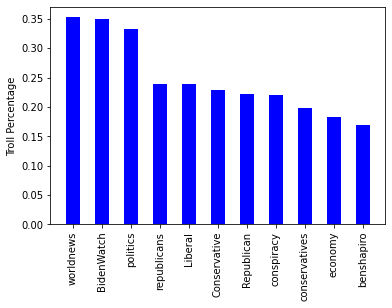

In [8]:
plt.bar(df_predictions_and_subreddits_grouped_by_sub['Subreddit'], df_predictions_and_subreddits_grouped_by_sub['Prediction'], width=0.5, color='blue')
plt.xticks(rotation=90)
plt.ylabel('Troll Percentage')
plt.show()

Here we see a general trend in the larger subreddits having the highest percentage of posts classified as "Troll" content, while somre more niche subreddits are a little lower. Lets look at the data over time.

In [9]:
times = []
time_sql = """
select created from posts
"""
cur.execute(time_sql)
all_times = cur.fetchall()
for i in all_times:
    times.append(i[0])
df_predictions_and_subreddits['created_unix'] = times

In [10]:
import datetime
def unix_to_date(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp).strftime('%Y-%m-%d')
df_predictions_and_subreddits['created_date'] = df_predictions_and_subreddits['created_unix'].apply(unix_to_date)

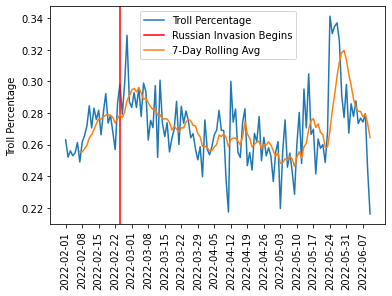

In [11]:
df_predictions_and_subreddits_groupby_date = df_predictions_and_subreddits.groupby('created_date', as_index=False).agg({'Prediction': 'mean'})
plt.plot(df_predictions_and_subreddits_groupby_date['created_date'], df_predictions_and_subreddits_groupby_date['Prediction'])
plt.ylabel('Troll Percentage')
plt.xticks(df_predictions_and_subreddits_groupby_date['created_date'][::7], rotation=90)
plt.axvline(x='2022-02-24', color='r')
plt.plot(df_predictions_and_subreddits_groupby_date['created_date'], df_predictions_and_subreddits_groupby_date['Prediction'].rolling(7).mean())
plt.legend(['Troll Percentage', 'Russian Invasion Begins', '7-Day Rolling Avg'])
plt.show()

The vertical red line shows when Russia invaded Ukraine (Feb 24), and we can see from the moving average that there is a downward trend occuring about a week afterward.

It looks like there's another increase in activity around 5-24. Although I'm not sure what the conversation was. We'll do some NLP on the date range 5-24 through 6-8 next:

In [12]:
def date_to_unix(date):
    return int(datetime.datetime.strptime(date, '%Y-%m-%d').timestamp())
start_date_unix = date_to_unix('2022-05-23')
end_date_unix = date_to_unix('2022-06-08')

In [13]:
specific_time_sql = """
select string_agg(title, ',') from (
    select distinct title from posts where created >= %s and created <= %s and title not like %s
) as subQ
"""
reddit_live_thread_blocker = '%Live Thread%'
cur.execute(specific_time_sql, (start_date_unix, end_date_unix, reddit_live_thread_blocker))
posts_within_range_response = cur.fetchall()
posts_within_range_list = []
for i in posts_within_range_response:
    posts_within_range_list.append(str(i[0]))

In [14]:
from nltk.tokenize import word_tokenize
def get_corpus(source_list):
    corpus = []
    for i in source_list:
        words = word_tokenize(i)
        corpus.append(' '.join([w for w in words if w not in stop]))
    return corpus
corpus = get_corpus(posts_within_range_list)

In [15]:
def generate_top_ngrams(corpus):
    vec = CountVectorizer(ngram_range=(4, 4), lowercase=False)
    vec.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]
top_ngrams = generate_top_ngrams(corpus)[:10]
x,y = map(list,zip(*top_ngrams))
output = list(zip(x,y))
df_ngrams = pd.DataFrame(output, columns=['ngram', 'count'])
print(df_ngrams)

                              ngram  count
0           Johnny Depp Amber Heard     21
1  Texas elementary school shooting     20
2           Russia Ukraine war News     17
3             Texas Gov Greg Abbott     14
4         Nancy Pelosi husband Paul     13
5    killed Texas elementary school     11
6    targeted attack Israeli forces     11
7      killed Texas school shooting     10
8       Johnny Depp wins defamation     10
9       defamation case Amber Heard     10


This was a busy timeframe: Depp Heard Cour Case, Uvalde School Shooting, and the death of Shireen Aby Akleh. Lets Use the Existing lists & Dataframes to only look at Bot Posts

In [16]:
full_data_df = pd.DataFrame({'Subreddit': all_posts_subreddits, "Submission": all_posts_posts, 'Prediction': predictions, 'created_unix': times, 'created_date': times})
full_data_non_trolls = full_data_df[full_data_df['Prediction'] == 0]
full_data_trolls = full_data_df[full_data_df['Prediction'] == 1]
full_data_non_trolls = full_data_non_trolls[full_data_non_trolls['created_unix'] >= start_date_unix]
full_data_trolls = full_data_trolls[full_data_trolls['created_unix'] >= start_date_unix]
full_data_non_trolls = full_data_non_trolls.drop_duplicates(subset=['Submission'], keep = 'first')
full_data_trolls = full_data_trolls.drop_duplicates(subset=['Submission'],keep = 'first')
print(f' {len(full_data_non_trolls)} non-troll posts, {len(full_data_trolls)} troll posts')

 20724 non-troll posts, 8964 troll posts


In [17]:
corpus = get_corpus(full_data_non_trolls['Submission'])
top_ngrams = generate_top_ngrams(corpus)[:10]
x,y = map(list,zip(*top_ngrams))
output = list(zip(x,y))
df_ngrams_non_trolls = pd.DataFrame(output, columns=['ngram', 'count'])
corpus = get_corpus(full_data_trolls['Submission'])
top_ngrams = generate_top_ngrams(corpus)[:10]
x,y = map(list,zip(*top_ngrams))
output = list(zip(x,y))
df_ngrams_trolls = pd.DataFrame(output, columns=['ngram', 'count'])
print("---------Here are posts for non-trolls:")
print(df_ngrams_non_trolls)
print("\n---------Here are posts for trolls:")
print(df_ngrams_trolls)

---------Here are posts for non-trolls:
                             ngram  count
0          Johnny Depp Amber Heard     17
1    WorldNews Live Thread Russian     17
2     Live Thread Russian Invasion     17
3  Thread Russian Invasion Ukraine     17
4     Russian Invasion Ukraine Day     17
5     range rocket systems Ukraine     11
6          Tampa Bay Rays Facility      9
7          Rays Facility Over Team      8
8          Russia Ukraine war News      8
9      After Texas School Shooting      7

---------Here are posts for trolls:
                              ngram  count
0  Texas elementary school shooting     19
1         Nancy Pelosi husband Paul     12
2    killed Texas elementary school     11
3    targeted attack Israeli forces     11
4  shooting Texas elementary school     10
5      killed Texas school shooting     10
6     New evidence suggests Shireen     10
7     evidence suggests Shireen Abu     10
8        suggests Shireen Abu Akleh     10
9          Shireen Abu Akleh ki

I'm not sure where we went wrong with duplicates in the N gram analysis, but we can definitely see some differences in the post types. The non-troll seems to be full of Depp v Heard, worldnews livethread for Ukraine invasion, then the Uvalde School Shooting. Troll-oriented posts Cover Uvalde, Nancy Pelosi's husband being arrested, and Shireen Abu Akleh being killed by Isreali forces.